# **Evaluating the Impact of Reminder Emails on Admissions Exam Completion Rates: An A/B Testing Approach**
---
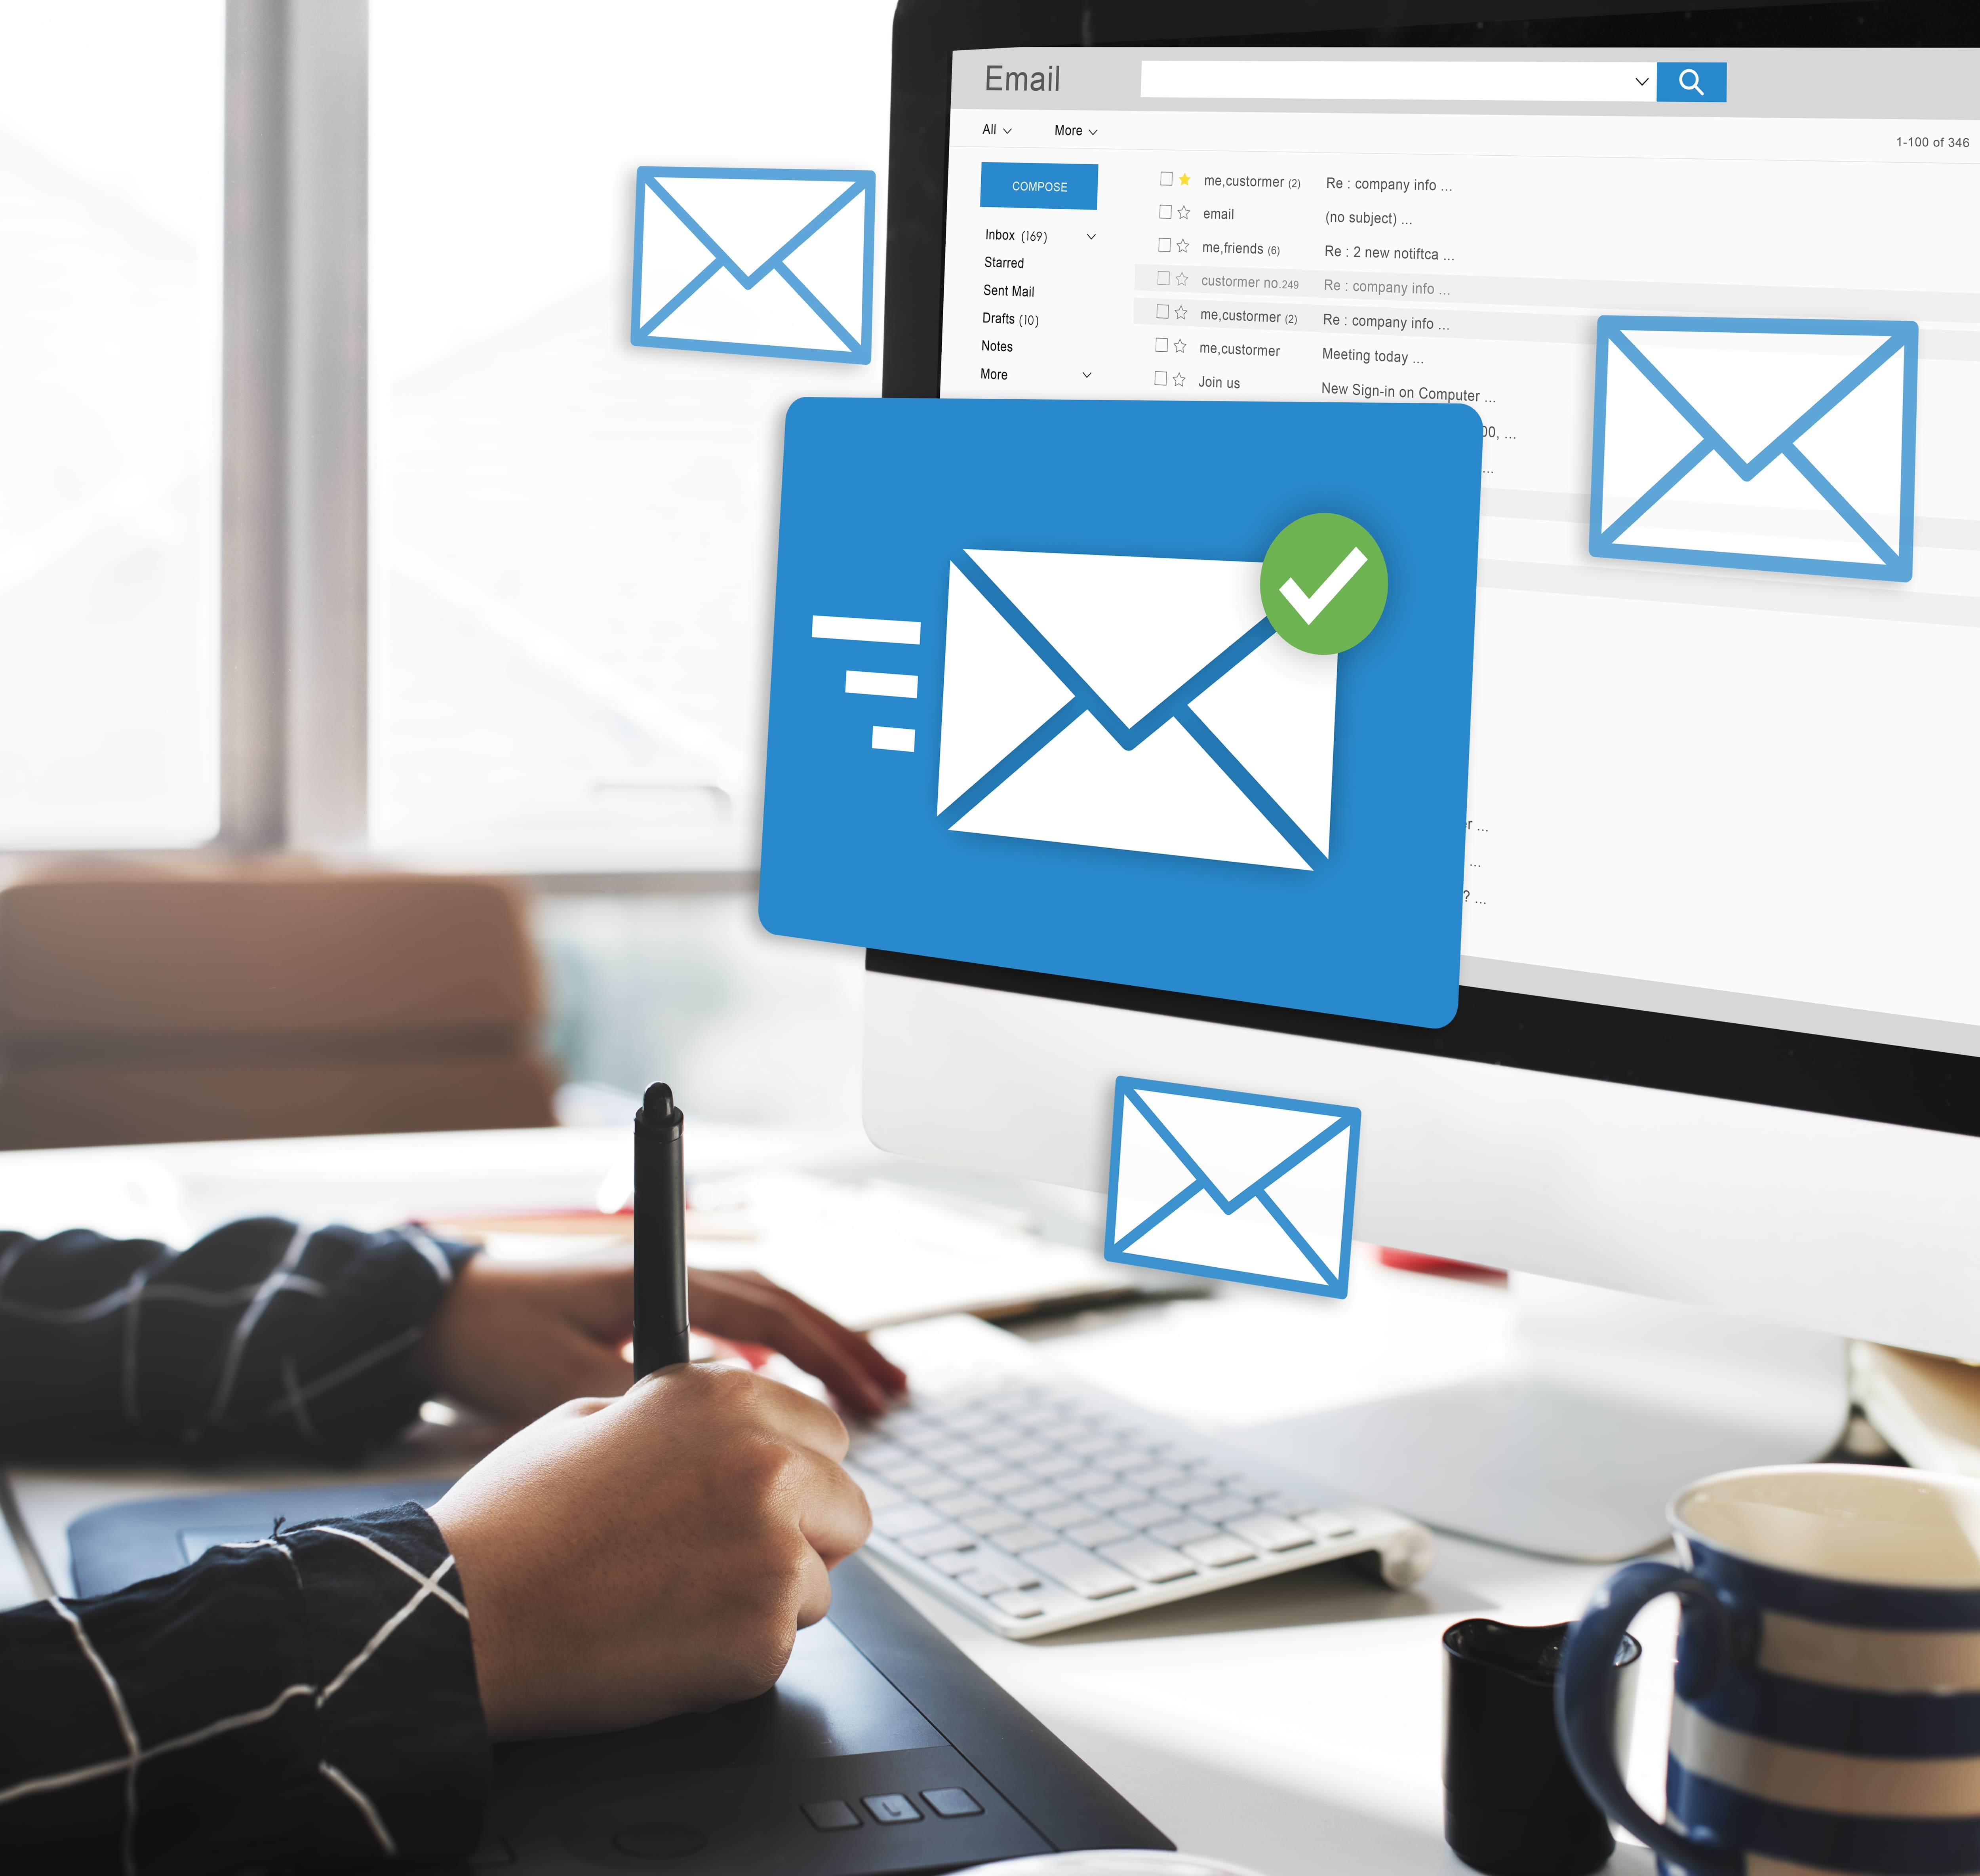
---


In many online learning platforms, a significant challenge lies in converting user registrations into meaningful engagement. One notable example is the gap between users who sign up and those who complete essential onboarding steps, such as an admissions exam. This drop-off represents a missed opportunity for both users and platforms, potentially affecting learning outcomes and user retention.

This project addresses the problem of low admissions exam completion rates by investigating whether behavioral nudges, in the form of reminder emails, can improve user follow-through. Using synthetic data, we will conduct a controlled **A/B test** to evaluate the effectiveness of reminder interventions.

To make the analysis accessible and actionable, we will develop an interactive web application using **Plotly Dash**. The app will enable stakeholders to visualize key metrics, explore A/B test results, and understand the impact of reminders on user behavior. By combining experimental analysis with a user-friendly interface, this project delivers insights that can guide data-driven strategies for enhancing user engagement in digital education platforms.

---

**PS.: This project was carried out using Google Colab**

---

## **Watch the Demo Video of the App**

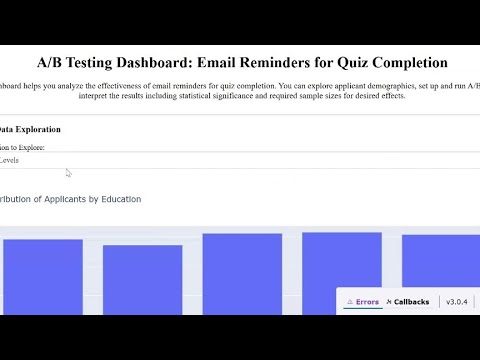

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('AB5f30eg3Dc', width=640, height=360)

## **Let's Get Started!!**

In [ ]:
# Install all dependencies

!pip install country_converter
!pip install pymongo
!python -m pip install python-dotenv==0.13.0
!pip install pyngrok
!pip install dash dash-bootstrap-components requests plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.1
    Uninstalling Flask-3.1.1:
      Successfully uninstalled Flask-3.1.1


In [ ]:
from pprint import PrettyPrinter
import pandas as pd
import plotly.express as px
from country_converter import CountryConverter
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower
from datetime import datetime, timedelta
from pyngrok import ngrok
from dotenv import load_dotenv
import os

## **Connect to MongoDB Atlas (Cloud)**

*   Go to [MongoDB Atlas](https://www.mongodb.com/cloud/atlas/register)
*   Sign up and create a free cluster under the **Overview** section.
*   Under **Database Access**, create a user with username/password authentication.
*   Under **Network Access**, whitelist all IPs (set to 0.0.0.0/0).
*   Undr the **Overview**, click on **Get Connection String**. Copy your MongoDB connection string. It will look like this:

**mongodb+srv://[username]:[password]@[cluster-url]/test?retryWrites=true&w=majority**
*   Assign your connection string to the MONGODB_URI in the `.env` file, which we create below.

---




We are going to store the MongoDB string and Ngrok token in a `.env`file to avoid hardcoding them directly into our code and potentially exposing them publicly. The ngrok token will be used to create a publicly accessible URL for our web appliacation. You can get your ngrok token [here](https://ngrok.com/) after creating an ngrok account.

In [ ]:
# Define the file path
env_file_path = os.path.join(os.getcwd(), ".env")  # Create in current directory

# Insert your MongoDB connection string and Ngrok token below (dont share them with anyone)
# In your MongoDB string, insert the user password you created under 'Database Access' section within the angle brackets <>
# Ensure you delete the angle brackets <> after inserting your user password
env_vars = {
    "MONGODB_URI": "INSERT MONGODB STRING HERE",
    "NGROK_ATK": "INSERT NGROK TOKEN HERE",
}
# Write the variables to the .env file
with open(env_file_path, "w") as f:
    for key, value in env_vars.items():
        f.write(f"{key}={value}\n")

print(f".env file created at: {env_file_path}")

In [ ]:
from pymongo import MongoClient

# Load config from a .env file:
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to your MongoDB cluster:
client = MongoClient(MONGODB_URI)

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [ ]:
#  Instantiate PrettyPrinter
pp = PrettyPrinter(indent=2)
print("pp type:", type(pp))

pp type: <class 'pprint.PrettyPrinter'>


In [ ]:
# Print a list of the databases available on client
pp.pprint(list(client.list_databases()))

[ {'empty': False, 'name': 'frank-db', 'sizeOnDisk': 3727360},
  {'empty': False, 'name': 'sample_mflix', 'sizeOnDisk': 115204096},
  {'empty': False, 'name': 'admin', 'sizeOnDisk': 319488},
  {'empty': False, 'name': 'local', 'sizeOnDisk': 15353790464}]


Go to the MongoDB website, under the **Overview** section click on **Browse Collections**, then on **Create Database**. In this project, we will create a database named `frank-db`. After creating your database, click on the plus (+) sign next to it to add a **collection**. In this project, we will name our collection `hypothesis-test`.

In [ ]:
# assign the database 'frank-db' to db
db = client['frank-db']

# Get the names of the collections in 'frank-db'
for c in db.list_collections():
  print(c["name"])

air-quality
hypothesis-test


In [ ]:
# Assign the "hypothesis-test" collection in the "frank-db" database to the variable name 'hypo_test'
hypo_test = db["hypothesis-test"]

# Count documents in `hypo_test`
n_documents = hypo_test.count_documents({})
print("Number of documents in hypo_test collection:", n_documents)

Number of documents in hypo_test collection: 0


## **Create Synthetic A/B (Hypothesis) Testing Data**

Since the log in details of the applicants contain confidential information, we cannot use real data for this experiment. Hence, we are going to create a synthetic data using the `Faker` library (a Python package used to generate fake data—such as names, addresses, emails, phone numbers, dates, and even entire user profiles). We are going to generate 1000 fake user records for the January and Febuary and add them to our `hypothesis-test` collection.

In [ ]:
!pip install faker pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.4 MB/s eta 0:00:00


In [ ]:
import random
from faker import Faker
from bson import ObjectId

# Initialize Faker
fake = Faker()
Faker.seed(42)
random.seed(42)

# Generate random values for certain fields
GENDERS = ["male", "female", "other"]
DEGREES = ["High school", "Associate degree", "Bachelor's degree", "Master's degree", "PhD"]
ADMISSIONS_STATUS = ["complete", "incomplete"]
COUNTRIES = ["US", "GB", "CA", "AU", "DE", "FR", "IN", "NG", "BR", "CN"]

def generate_user():
    # Define start and end date for Jan 1 – Feb 29, 2025
    start_date = datetime(2025, 1, 1)
    end_date = datetime(2025, 2, 28, 23, 59, 59)

    # Generate a random datetime within that range
    time_between_dates = end_date - start_date
    random_number_of_days = random.randint(0, time_between_dates.days)
    random_seconds = random.randint(0, 86399)  # seconds in a day
    random_created_at = start_date + timedelta(days=random_number_of_days, seconds=random_seconds)

    return {
        "_id": ObjectId(),
        "admissionsQuiz": random.choice(ADMISSIONS_STATUS),
        "birthday": datetime.combine(fake.date_of_birth(minimum_age=18, maximum_age=60), datetime.min.time()),
        "countryISO2": random.choice(COUNTRIES),
        "createdAt": random_created_at,
        "email": fake.email(),
        "firstName": fake.first_name(),
        "gender": random.choice(GENDERS),
        "highestDegreeEarned": random.choice(DEGREES),
        "lastName": fake.last_name()
    }

# Generate 1,000 user records
users = [generate_user() for _ in range(1000)]

# Print the first few generated records
for i in range(5):
    print(users[i])  # Preview 5 records

{'_id': ObjectId('682f08ff704f53cd46eb46a4'), 'admissionsQuiz': 'complete', 'birthday': datetime.datetime(1991, 11, 19, 0, 0), 'countryISO2': 'DE', 'createdAt': datetime.datetime(2025, 2, 10, 4, 3, 12), 'email': 'figueroajohn@example.org', 'firstName': 'Jill', 'gender': 'male', 'highestDegreeEarned': 'Associate degree', 'lastName': 'Rhodes'}
{'_id': ObjectId('682f08ff704f53cd46eb46a5'), 'admissionsQuiz': 'complete', 'birthday': datetime.datetime(2002, 10, 1, 0, 0), 'countryISO2': 'CN', 'createdAt': datetime.datetime(2025, 1, 9, 3, 43, 54), 'email': 'garzaanthony@example.org', 'firstName': 'Jeffery', 'gender': 'female', 'highestDegreeEarned': 'High school', 'lastName': 'Wagner'}
{'_id': ObjectId('682f08ff704f53cd46eb46a6'), 'admissionsQuiz': 'complete', 'birthday': datetime.datetime(1965, 7, 12, 0, 0), 'countryISO2': 'AU', 'createdAt': datetime.datetime(2025, 1, 2, 3, 24, 40), 'email': 'jennifermiles@example.com', 'firstName': 'Jeffrey', 'gender': 'other', 'highestDegreeEarned': 'PhD', 

In [ ]:
# Insert the synthetic data into the 'hypothesis-test' collection
hypo_test.insert_many(users)

# Retrieve one document from the 'hypothesis-test' collection
hypo_test.find_one({})

{'_id': ObjectId('682f08ff704f53cd46eb46a4'),
 'admissionsQuiz': 'complete',
 'birthday': datetime.datetime(1991, 11, 19, 0, 0),
 'countryISO2': 'DE',
 'createdAt': datetime.datetime(2025, 2, 10, 4, 3, 12),
 'email': 'figueroajohn@example.org',
 'firstName': 'Jill',
 'gender': 'male',
 'highestDegreeEarned': 'Associate degree',
 'lastName': 'Rhodes'}

In [ ]:
# Count the number of documents in the collection
hypo_test.count_documents({})

1000

## **Exploratory Data Analysis**

In [ ]:
# Get the minimum and maximum dates in the hypo_test collection
result = hypo_test.aggregate([
    {
        '$group': {
            '_id': None,
            'minDate': {'$min': '$createdAt'},
            'maxDate': {'$max': '$createdAt'}
        }
    }
])

# Extract the dates from the result
date_range = list(result)[0]
min_date = date_range['minDate']
max_date = date_range['maxDate']

# Convert the dates to pandas DateTime objects
min_date = pd.to_datetime(min_date)
max_date = pd.to_datetime(max_date)

# Print the date range
print(f"Date range in 'hypo_test' collection: {min_date} to {max_date}")

Date range in 'hypo_test' collection: 2025-01-01 00:17:36 to 2025-02-28 20:35:41


In [ ]:
# check the unique types of gender available
hypo_test.distinct("gender")

['female', 'male', 'other']

In [ ]:
# check the number of documents for each gender type
result = hypo_test.aggregate([{"$group":{"_id":"$gender","count":{"$count":{}}}}])
pp.pprint(list(result))

[ {'_id': 'female', 'count': 338},
  {'_id': 'male', 'count': 310},
  {'_id': 'other', 'count': 352}]


In [ ]:
# check the unique types of degrees available
hypo_test.distinct("highestDegreeEarned")

['Associate degree',
 "Bachelor's degree",
 'High school',
 "Master's degree",
 'PhD']

In [ ]:
# check the number of documents for each 'highestDegreeEarned' type
result = hypo_test.aggregate([{"$group":{"_id":"$highestDegreeEarned","count":{"$count":{}}}}])
pp.pprint(list(result))

[ {'_id': 'High school', 'count': 196},
  {'_id': 'Associate degree', 'count': 186},
  {'_id': 'PhD', 'count': 204},
  {'_id': "Bachelor's degree", 'count': 206},
  {'_id': "Master's degree", 'count': 208}]


In [ ]:
# check the number of 'female' records for each type in 'highestDegreeEarned'
result = hypo_test.aggregate([{"$match":{"gender":"female"}},{"$group":{"_id":"$highestDegreeEarned","count":{"$count":{}}}}])
pp.pprint(list(result))

[ {'_id': "Master's degree", 'count': 70},
  {'_id': "Bachelor's degree", 'count': 71},
  {'_id': 'High school', 'count': 73},
  {'_id': 'Associate degree', 'count': 62},
  {'_id': 'PhD', 'count': 62}]


In [ ]:
#Get the number of applicants in each country
result = hypo_test.aggregate([{'$group':{'_id':'$countryISO2',
                                         'count':{'$count':{}}}}])
df_nationality =(pd.DataFrame(result)
                  .rename({'_id':'country_iso2'},axis='columns')
                  .sort_values('count')
                 )

print("df_nationality type:", type(df_nationality))
print("df_nationality shape", df_nationality.shape)
df_nationality.head()

df_nationality type: <class 'pandas.core.frame.DataFrame'>
df_nationality shape (10, 2)


,country_iso2,count
9,FR,85
7,US,88
1,DE,99
2,CN,100
0,AU,102


In [ ]:
# Add a new column that provides the full name of each country, based on its ISO2 code

# Instantiate `CountryConverter`
cc=CountryConverter()

# Create `"country_name"` column
df_nationality['country_name']=cc.convert(df_nationality['country_iso2'],
                                          to='name_short')

print("df_nationality shape:", df_nationality.shape)
df_nationality.head()

df_nationality shape: (10, 3)


,country_iso2,count,country_name
9,FR,85,France
7,US,88,United States
1,DE,99,Germany
2,CN,100,China
0,AU,102,Australia


In [ ]:
# Get the proportion of applicants in each country
df_nationality["count_pct"] = df_nationality['count']/(df_nationality['count'].sum())*100

# Create horizontal bar chart
fig =px.bar(data_frame=df_nationality.tail(10),x='count_pct',
            y='country_name', orientation='h',
               title="Top Ten Countries of Applicants: Proportion of Applicants from Each Country"
              )
fig.update_layout(xaxis_title='Country',yaxis_title='Frequency [count]'
                     )
# Set axis labels

fig.show()

We can see that largest proportion of applicants are from the United Kingdom, and the African country with the largest proportion is Nigeria.

In [ ]:
 # Visualize the percentage of gender types within the top countries

 # Get the number of applicants for each gender in each country
result_gender_country = hypo_test.aggregate([
    {'$group': {
        '_id': {'country': '$countryISO2', 'gender': '$gender'},
        'count': {'$count': {}}
    }}
])

df_gender_country = pd.DataFrame(result_gender_country)

# Rename columns for clarity
df_gender_country = df_gender_country.rename(
    columns={'_id': 'country_gender', 'count': 'count'}
)

# Separate country and gender into different columns
df_gender_country['country_iso2'] = df_gender_country['country_gender'].apply(lambda x: x['country'])
df_gender_country['gender'] = df_gender_country['country_gender'].apply(lambda x: x['gender'])

# Drop the original combined column
df_gender_country = df_gender_country.drop(columns=['country_gender'])

# Add full country names
cc = CountryConverter()
df_gender_country['country_name'] = cc.convert(df_gender_country['country_iso2'], to='name_short')

# Identify the top 10 countries based on the total number of applicants
top_countries_iso2 = df_nationality.tail(10)['country_iso2'].tolist()

# Filter the gender by country DataFrame to include only the top 10 countries
df_top_countries_gender = df_gender_country[df_gender_country['country_iso2'].isin(top_countries_iso2)].copy()

# Calculate the total count per country within the filtered data
total_count_per_country = df_top_countries_gender.groupby('country_iso2')['count'].transform('sum')

# Add a column for total count per country to the filtered DataFrame
df_top_countries_gender['total_country_count'] = total_count_per_country

# Calculate the percentage of each gender within each country
df_top_countries_gender['percentage'] = (df_top_countries_gender['count'] / df_top_countries_gender['total_country_count']) * 100

# Sort the DataFrame by total country count (descending) for better visualization
df_top_countries_gender = df_top_countries_gender.sort_values(by='total_country_count', ascending=False)

# Create a grouped bar chart for percentages
fig_gender_percentage = px.bar(
    data_frame=df_top_countries_gender,
    x='country_name',
    y='percentage',
    color='gender',
    title='Percentage of Gender Types in Top 10 Countries',
    labels={'country_name': 'Country', 'percentage': 'Percentage (%)', 'gender': 'Gender'}
)

fig_gender_percentage.update_layout(barmode='group')
fig_gender_percentage.show()

In [ ]:
#Build a world map to show the number of applicants in each country

# Create a 'country_iso3' column to store the ISO 3166-1 alpha-3 codes
df_nationality['country_iso3']=cc.convert(df_nationality['country_iso2'],
                                          to='ISO3')

# Build plotly choropleth map
fig = px.choropleth(data_frame=df_nationality,
                      locations='country_iso3',
                      color='count',
                      projection='natural earth',
                      color_continuous_scale= px.colors.sequential.Greens,
                      title="Applicants: Nationalities"
                     )
fig.show()

In [ ]:
# Plot the distribution of Applicants' ages

# Calculate the age of each applicant in 'hypo_test'
result = hypo_test.aggregate([
    {'$project':{'years':{'$dateDiff':{'startDate':
        '$birthday','endDate':'$$NOW','unit':'year'}}}}])

# Save your 'result' in a dataframe
ages_df = pd.DataFrame(result)['years']

# Create histogram of `ages`
fig = px.histogram(x=ages_df,nbins=20,title="Distribution of Applicants' Ages")
# Set axis labels
fig.update_layout(xaxis_title='Age',yaxis_title='Frequency [count]')

fig.show()

We can see that majority of the applicants are in their 30s and 40s. We can also see that there are a few teenage applicants.

In [ ]:
# Get the number of applicants according to highest degree earned
result = hypo_test.aggregate([{"$match":{"gender":"female"}},{"$group":{"_id":"$highestDegreeEarned","count":{"$count":{}}}}])
# Put the result in a dataframe
education_df = (
    pd.DataFrame(result)
    .rename(
    {'_id':'highest_degree_earned'},
    axis='columns'
    ).set_index('highest_degree_earned').squeeze()
)
education_df

,count
highest_degree_earned,
High school,73
Associate degree,62
PhD,62
Bachelor's degree,71
Master's degree,70


In [ ]:
# Sort the educational levels in ascending order
degree_order = ["High school", "Associate degree", "Bachelor's degree", "Master's degree", "PhD"]
education_df.index = pd.CategoricalIndex(education_df.index, categories=degree_order, ordered=True)
education_df = education_df.sort_index()
education_df

,count
highest_degree_earned,
High school,73
Associate degree,62
Bachelor's degree,71
Master's degree,70
PhD,62


In [ ]:
# Create a bar chart to show the educational levels of applicants
fig =px.bar(x=education_df,
            y=education_df.index,
            orientation='h',
            title="Applicants Educational Levels"
)
fig.update_layout(xaxis_title='Frequency [count]',
                  yaxis_title="Highest Degree Earned"
)

fig.show()

In [ ]:
# Get the number of applicants that completed and did not complete the admissions quiz
result = hypo_test.aggregate([
    {'$group':{'_id':'$admissionsQuiz',
               'count':{'$count':{}}}}])
for r in result:
    if r['_id']=='incomplete':
        incomplete=r['count']
    else:
        complete=r['count']

print("Completed quiz:", complete)
print("Did not complete quiz:", incomplete)
print("")
# Get the proportion of applicants that completed and did not complete the admissions quiz
print("Completed quiz (Percentage):", round(complete/(complete+incomplete)*100,2),"%")
print("Did not complete quiz (Percentage):", round(incomplete/(complete+incomplete)*100,2),"%")

Completed quiz: 507
Did not complete quiz: 493

Completed quiz (Percentage): 50.7 %
Did not complete quiz (Percentage): 49.3 %


We can see that almost half of the aplicants who registered an account did not complete the admission quiz. We may come up with an assumption to solve the problem, say sending a reminder email to the 'no-quiz' applicants **will** increase the rate of quiz completion. This assumption is our **alternate hypothesis**. Hence, the opposite - our **null hypothesis**, says that sending a reminder email to the 'no-quiz' applicants **will not** increase the rate of quiz completion. We are going to conduct an experiment (**A/B Testing**) to either accept or reject the null hypothesis.

## **Run the Hypothesis Test**

### **1. Extract, Transform, Load (ETL)**

First, we are going to extract the records of the no-quiz applicants (those who did not complete the admission quiz). We will build a `find_by_date_range` function to help us achieve that.

In [ ]:
def find_by_date_range(collection, start_date_str, end_date_str):
    """Find records in a PyMongo Collection created within a given date range
    and with 'admissionsQuiz' status as 'incomplete'.

    Parameters
    ----------
    collection : pymongo.collection.Collection
        Collection in which to search for documents.
    start_date_str : str
        Start date of the range. Format must be '%Y-%m-%d', e.g. '2023-09-01'.
    end_date_str : str
        End date of the range. Format must be '%Y-%m-%d', e.g. '2023-09-05'.

    Returns
    -------
    observations : list
        Result of query. List of documents (dictionaries) matching the criteria.
    """
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    # Convert end date string to datetime and add one day to include the whole end day
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d') + pd.DateOffset(days=1)

    # Construct the query
    query = {
        "createdAt": {
            "$gte": start_date,
            "$lt": end_date
        },
        # Filter for admissionsQuiz status
        'admissionsQuiz': "incomplete"
    }
    results = collection.find(query)
    results = list(results)
    return results

In [ ]:
# Get the records of no-quiz applicants that registered in January and Febuary 2025
observations = find_by_date_range(hypo_test, "2025-01-01", "2025-02-28")
print("observations len:", len(observations))

# Check if the list is empty before accessing elements
if observations:
    print(observations[0])
else:
    print("No observations found for the specified date.")

observations len: 493
{'_id': ObjectId('682f08ff704f53cd46eb46a8'), 'admissionsQuiz': 'incomplete', 'birthday': datetime.datetime(2005, 7, 19, 0, 0), 'countryISO2': 'US', 'createdAt': datetime.datetime(2025, 1, 29, 21, 27, 16), 'email': 'curtis61@example.com', 'firstName': 'Melanie', 'gender': 'male', 'highestDegreeEarned': "Master's degree", 'lastName': 'Munoz'}


This confirms what we saw earlier where 507 applicants completed the quiz and 493 applicants did not complete quiz. We are going to split the no-quiz applicants ( applicants who didn't take the admission quiz) into two groups:

1) A group that will receive a reminder email (the **treatment group**), and

2) A group that will not receive a reminder email (the **control group**).

In [ ]:
def assign_to_groups(observations):
    """Randomly assigns observations to control and treatment groups.

    Parameters
    ----------
    observations : list or pymongo.cursor.Cursor
        List of users to assign to groups.

    Returns
    -------
    observations : list
        List of documents from `observations` with two additional keys:
        `inExperiment` and `group`.
    """
    random.seed(42)
    random.shuffle(observations)
    idx=len(observations)//2
    for doc in observations[:idx]:
        doc['inExperiment']=True
        doc['group']='no email (control)'
    for doc in observations[idx:]:
        doc['inExperiment']=True
        doc['group']='email (treatment)'
    return observations

In [ ]:
observations_assigned = assign_to_groups(observations)
print("observations_assigned len:", len(observations_assigned))
print()
# Print the first observation
observations_assigned[0]

observations_assigned len: 493



{'_id': ObjectId('682b48553a305024e95a3164'),
 'admissionsQuiz': 'incomplete',
 'birthday': datetime.datetime(1965, 1, 10, 0, 0),
 'countryISO2': 'BR',
 'createdAt': datetime.datetime(2025, 2, 22, 19, 1, 35),
 'email': 'brenda63@example.org',
 'firstName': 'Tanya',
 'gender': 'other',
 'highestDegreeEarned': "Master's degree",
 'lastName': 'Perkins',
 'inExperiment': True,
 'group': 'no email (control)'}

In [ ]:
# Print the last observation
observations_assigned[-1]

{'_id': ObjectId('682b48553a305024e95a3264'),
 'admissionsQuiz': 'incomplete',
 'birthday': datetime.datetime(1972, 1, 30, 0, 0),
 'countryISO2': 'DE',
 'createdAt': datetime.datetime(2025, 2, 15, 9, 44, 18),
 'email': 'eric99@example.org',
 'firstName': 'Kathleen',
 'gender': 'female',
 'highestDegreeEarned': "Bachelor's degree",
 'lastName': 'Guerrero',
 'inExperiment': True,
 'group': 'email (treatment)'}

We will build the `export_treatment_email` function to help us create a CSV file containing the email addresses of users who have been assigned to the **treatment** group. This file could then be used to send reminder emails to the treatment group participants.

In [ ]:
def export_treatment_emails(observations_assigned, directory="."):
    """Creates CSV file with email addresses of observations in treatment group.

    CSV file name will include today's date, e.g. `'2025-01-11_ab-test.csv'`,
    and a `'tag'` column where every row will be 'ab-test'.

    Parameters
    ----------
    observations_assigned : list
        Observations with group assignment.
    directory : str, default='.'
        Location for saved CSV file.

    Returns
    -------
    None
    """
    # Put `observations_assigned` docs into DataFrame
    df = pd.DataFrame(observations_assigned)

    # Add `"tag"` column
    df['tag']='ab-test'

    # Create mask for treatment group only
    mask=df['group']=='email (treatment)'

    # Create filename with date
    date_string=pd.Timestamp.now().strftime(format='%Y-%m-%d')
    filename = directory + '/' + date_string + '_ab-test.csv'

    # Save DataFrame to directory (email and tag only)
    df[mask][['email','tag']].to_csv(filename,index=False)

In [ ]:
export_treatment_emails(observations_assigned=observations_assigned)
print("CSV file saved to:", os.getcwd())

We will build the `update_applicants` function that will help to take thr list of applicant documents that have been assigned to either a control or a treatment group and update the corresponding documents in our `hypo_test` collection. This update will add information about their participation in the experiment and their assigned group.

In [ ]:
# Retrieve the first document where 'admissionsQuiz' is 'incomplete'
hypo_test.find_one({'admissionsQuiz': 'incomplete'})

{'_id': ObjectId('682b48553a305024e95a2eda'),
 'admissionsQuiz': 'incomplete',
 'birthday': datetime.datetime(1985, 11, 26, 0, 0),
 'countryISO2': 'CA',
 'createdAt': datetime.datetime(2025, 1, 26, 23, 24, 19),
 'email': 'williamrodriguez@example.net',
 'firstName': 'Kenneth',
 'gender': 'female',
 'highestDegreeEarned': 'Associate degree',
 'lastName': 'Fowler'}

We can see that the information about the applicants in the experiment have not yet been added to our collection.

In [ ]:
def update_applicants(collection, observations_assigned):
    """Update applicant documents in the hypo_test collection.

    Parameters
    ----------
    collection : pymongo.collection.Collection
        Collection in which documents will be updated.

    observations_assigned : list
        Documents that will be used to update collection

    Returns
    -------
    transaction_result : dict
        Status of update operation, including number of documents
        and number of documents modified.
    """
    n=0
    n_modified=0
    for doc in observations_assigned:
        result=collection.update_one(filter={'_id':doc['_id']},
                                              update={'$set':doc})
        n+=result.matched_count
        n_modified+=result.modified_count
    transaction_result={'n':n,'nModified':n_modified} # number of times the collection has been modified

    return transaction_result

In [ ]:
# Update the collection with info related to the experiment
result = update_applicants(hypo_test, observations_assigned)
result

{'n': 493, 'nModified': 493}

In [ ]:
# Retrieve the first document where 'admissionsQuiz' is 'incomplete'
hypo_test.find_one({'admissionsQuiz': 'incomplete'})

Now we can see that the collection has been updated. We can know which applicant is in the experiment and the assigned group. So far, we have been able to extract data of no-quiz applicants from our MongoDB database using the `find_by_date_range` function, transform it using the `assign_to_groups` function, and load it using the `update_applicants` function. Next, we are going to incorporate these functions in Python classes, which we will later use to build our web application.

In [ ]:
class MongoRepository:
    """This class provides methods for finding documents within a date range,
    assigning documents to control and treatment groups for A/B testing,
    and updating documents in the collection.
    """

    def __init__(self,client=MongoClient(MONGODB_URI),
                 db='frank-db',
                 collection="hypothesis-test"
                ):
        self.collection=client[db][collection]


    def find_by_date_range(self, start_date_str, end_date_str):
        # Convert the date strings to datetime objects
        start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
        # Convert end date string to datetime and add one day to include the whole end day
        end_date = datetime.strptime(end_date_str, '%Y-%m-%d') + pd.DateOffset(days=1)

        # Construct the query
        query = {
            "createdAt": {
                "$gte": start_date,
                "$lt": end_date
            },
            # Filter for admissionsQuiz status
            'admissionsQuiz': "incomplete"
        }
        results = self.collection.find(query)
        results = list(results)
        return results

    def update_applicants(self,observations_assigned):
        n=0
        n_modified=0
        for doc in observations_assigned:
            result=self.collection.update_one(filter={'_id':doc['_id']},
                                              update={'$set':doc})
            n+=result.matched_count
            n_modified+=result.modified_count
        transaction_result={'n':n,'nModified':n_modified}
        return transaction_result

    def assign_to_groups(self, observations):
        random.seed(42)
        random.shuffle(observations)
        idx = len(observations) // 2
        for doc in observations[:idx]:
            doc['inExperiment'] = True
            doc["group"] = 'no email (control)'
        for doc in observations[idx:]:
            doc['inExperiment'] = True
            doc["group"] = 'email (treatment)'
        result = self.update_applicants(observations)
        return observations

In [ ]:
repo = MongoRepository()
repo.collection

Collection(Database(MongoClient(host=['ac-lej27ex-shard-00-00.h07wrvi.mongodb.net:27017', 'ac-lej27ex-shard-00-01.h07wrvi.mongodb.net:27017', 'ac-lej27ex-shard-00-02.h07wrvi.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-t1xdjz-shard-0', tls=True), 'frank-db'), 'hypothesis-test')

In [ ]:
# Let's test the find_by_date_range method in our MongoRepository class
# Get the records of no-quiz applicants that registered in January and Febuary 2025
observations = repo.find_by_date_range("2025-01-01", "2025-02-28")
print("observations len:", len(observations))

# Check if the list is empty before accessing elements
if observations:
    print(observations[0])
else:
    print("No observations found for the specified date.")

observations len: 493
{'_id': ObjectId('682f08ff704f53cd46eb46a8'), 'admissionsQuiz': 'incomplete', 'birthday': datetime.datetime(2005, 7, 19, 0, 0), 'countryISO2': 'US', 'createdAt': datetime.datetime(2025, 1, 29, 21, 27, 16), 'email': 'curtis61@example.com', 'firstName': 'Melanie', 'gender': 'male', 'highestDegreeEarned': "Master's degree", 'lastName': 'Munoz'}


### **2. Chi-Square Test**

Next, we will conduct a chi-square test to evaluate the results of our experiment. To do this, we will follow these steps:

1) Perform a **power calculation** to determine the number of observations needed to detect a meaningful difference between the treatment and control groups.

2) Use a **cumulative density function** to determine how long we will need to run the experiment.

3) Build a **contingency table** with the experiment results.

4) Finally, we conduct a **chi-square test** to determine if we will reject or accept the null hypothesis.

---

Let's begin with the first step.

In [ ]:
import math
import scipy
import numpy as np
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower
chi_square_power = GofChisquarePower()
group_size = math.ceil(
    chi_square_power.solve_power(effect_size=0.2,alpha=0.05,power=0.8)
)

print("Group size:", group_size)
print("Total number of applicants needed:", group_size * 2)

Group size: 197
Total number of applicants needed: 394


From the results above, if we want to detect an effect size of 0.2 we need a group size of about 200 people for each group (that is, a total of about 400 applicants in our experiment). If we needed to detect a larger effect size, we would need fewer applicants, and vice versa.

**N/B**  `Effect siz` represents the minimum difference in the outcome (admissions exam completion rate) that we want to be able to detect between the two groups. An effect size of 0.2 is considered a small to medium effect size in many fields.

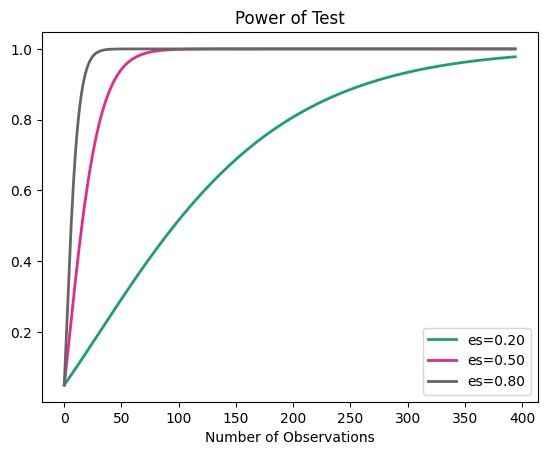

In [ ]:
# Let's visualize the relationship between effect size, statistical power, and group size
n_observations = np.arange(0,group_size*2 + 1)
effect_sizes = np.array([0.2,0.5,0.8])

# Plot power curve using `chi_square_power`
chi_square_power.plot_power(dep_var='nobs',
                            nobs=n_observations,
                            effect_size=effect_sizes,
                            alpha=0.05,
                            n_bins=2
);

We can see that at a statistical power of 0.8, to get an effect size of 0.2 we will need about 200 observations; to get an effect size of 0.5 we will need about 30 observations; and to get an effect size of 0.8, we will need about 10 observations. This shows that for a given statistical power, larger observations (group size) will be needed to detect smaller effect sizes, and vice versa.

Now that we know we need around 400 observations to get the desired effect size, the next thing we need to find out is how long do we need to run our experiment in order to get 400 observations. To answer this, we need to find out the number of *no-quiz* applicants that register each day.

date
2025-01-01     9
2025-01-02    10
2025-01-03     9
2025-01-04    11
2025-01-05    10
Name: new_users, dtype: int64


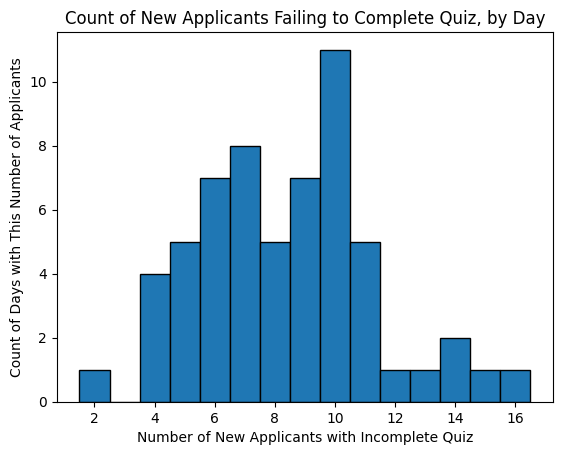

In [ ]:
# Get the number of no-quiz applicants that register each day
result = hypo_test.aggregate([
    {'$match':{
        'admissionsQuiz': 'incomplete'}},
    {'$group':
     {'_id':
            {"$dateTrunc":
                    {'date':'$createdAt','unit':'day'}},
                    'count':{'$sum':1}}}])

# Read the results in a DataFrame
no_quiz = (
    pd.DataFrame(result).rename({'_id':'date','count':'new_users'},axis=1)
    .set_index('date').sort_index().squeeze()
)

print(no_quiz.head())

# Create histogram of `no_quiz`
plt.hist(no_quiz, bins=np.arange(min(no_quiz)-0.5, max(no_quiz)+1.5, 1), edgecolor='black') #ensures that each integer count falls into its appropriate bin without gaps.

plt.xlabel("Number of New Applicants with Incomplete Quiz")
plt.ylabel("Count of Days with This Number of Applicants")
plt.title("Count of New Applicants Failing to Complete Quiz, by Day");

We can see that the highest number of *no-quiz* applicants that has ever been gotten in a day is 16 and that happened just once throughout the months of January and February.

---

Note that there are missing dates in the `no_quiz` series we just created above. These missing dates are the records of the applicants who completed the quiz. Using the data as it is to calculate the number of days required to get at least 400 applicants without, first of all, getting the full date range will lead to improper calculation of the number of days. We will need to preprocess the data to fill in those missing dates before running the code to calculate the required number of days. This preprocessing will involve:

* Converting the date column to datetime.
* Reindexing the DataFrame with a complete date range.
* Filling missing values with zero.

In [ ]:
# Create a full date range from the minimum to the maximum date in 'no_quiz' Series
full_range = pd.date_range(start=no_quiz.index.min(), end=no_quiz.index.max())

# Reindex the Series to include all dates, filling missing dates with 0
no_quiz_full = no_quiz.reindex(full_range, fill_value=0)
no_quiz_full.index.name = 'date'

print(no_quiz_full.head())

date
2025-01-01     9
2025-01-02    10
2025-01-03     9
2025-01-04    11
2025-01-05    10
Freq: D, Name: new_users, dtype: int64


In [ ]:
# Get the mean and standard deviation of the number of no-quiz applicants that register per day
mean = no_quiz_full.describe()['mean']
std =  no_quiz_full.describe()['std']
print("no_quiz mean:", mean)
print("no_quiz std:", std)

no_quiz mean: 8.35593220338983
no_quiz std: 2.922933763948102


This shows that an average of about 8 no-quiz applicants register on the online learning platform each day.

In [ ]:
# Estimate experiment duration (days)
days_needed = int(400 / mean)
print(f"Estimated experiment duration (days): {days_needed}")

Estimated experiment duration (days): 47


Hence, to get 400 observations, we will need to run the experiment for 47 days. But it's likely that we will get more or less than 8 *no-quiz* applicants per day. To confirm if we need 47 days to get 400 observations, we will use a **cumulatie density function** to know the probability that we will have 400 or more *no-quiz* applicants after 47 days.

In [ ]:
"""Calculate the mean and standard deviation of the probability distribution
for the total number of 'no-quiz' sign-ups over a specified number of days
"""
days = 47
sum_mean = mean * days
sum_std = std * np.sqrt(days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

# Calculate the probability that we will have 400 or more no-quiz applicants the specified number of days
prob_400_or_fewer = scipy.stats.norm.cdf(
    group_size*2,loc=sum_mean,scale=sum_std
)
prob_400_or_greater =1 - prob_400_or_fewer

print(
    f"Probability of getting 400+ no_quiz in {days} days:",
    round(prob_400_or_greater, 3),
)

Mean of sum: 392.728813559322
Std of sum: 20.038624305478344
Probability of getting 400+ no_quiz in 47 days: 0.475


From the cumulative density function, the probability of getting 400 observations after 47 days is low (0.475). On average, we will get about 393 observations over 47 days. Let's use 50 days instead and see what probability it gives.

In [ ]:
"""Calculate the mean and standard deviation of the probability distribution
for the total number of 'no-quiz' sign-ups over a specified number of days
"""
days = 50
sum_mean = mean * days
sum_std = std * np.sqrt(days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

# Calculate the probability that we will have 400 or more no-quiz applicants the specified number of days
prob_400_or_fewer = scipy.stats.norm.cdf(
    group_size*2,loc=sum_mean,scale=sum_std
)
prob_400_or_greater =1 - prob_400_or_fewer

print(
    f"Probability of getting 400+ no_quiz in {days} days:",
    round(prob_400_or_greater, 3),
)

Mean of sum: 417.79661016949154
Std of sum: 20.668262854468225
Probability of getting 400+ no_quiz in 50 days: 0.875


The probability of getting 400 observations after 50 days is high enough (0.875). On average, we will get about 418 observations over 50 days. Hence, we will run the experiment for 50 days.

---

Since we are working with synthetic data, We will build an `Experiment` class to simulate and analyze the A/B test (or hypothesis test) of sending reminder emails to applicants who haven't completed an admissions quiz. The class will interact with our MongoDB database to manage applicant data and track the experiment's progress. The `Experiment` class will provide a structured way to:

* Select applicants for the A/B test.
* Randomly assign them to control and treatment groups.
* Track their progress (whether they complete the admissions quiz).
* Analyze the results to determine if sending reminder emails had a significant impact on quiz completion rates.

In [ ]:
import random
class Experiment:
    """Run A/B test sending emails.

    Parameters
    ----------
    repo : `MongoRepository`
    """
    def __init__(self, repo):
        self.repo = repo

    def reset_experiment(self):
        """Reset experiment to original state (before groups assigned)."""
        result = self.repo.collection.update_many(
            filter={'inExperiment': True},
            update={'$set': {'inExperiment': False, 'group': None}}
        )
        return result

    def run_experiment(self, days=1700, completion_prob_treatment=0.2, completion_prob_control=0.05):  #
        """Run experiment for given number of days.

        Parameters
        ----------
        days : int, default=230
            Number of days back from the most recent createdAt value to select applicants.
        completion_prob_treatment : float, default=0.2
            Probability of an applicant in the treatment group completing the admissions quiz.
        completion_prob_control : float, default=0.05
            Probability of an applicant in the control group completing the admissions quiz.

        Returns
        -------
        results : dict
            Dictionary with results of experiment, including
            number of observations assigned to each group, and
            overall completion rate for each group.
        """

        # Get the maximum 'createdAt' value (most recent)
        max_date_doc = self.repo.collection.find_one(sort=[('createdAt', -1)])
        max_date = max_date_doc['createdAt']

        # Calculate start date (days back from max_date or most recent date)
        start_date = max_date - timedelta(days=days)

        start_date_string = start_date.strftime(format='%Y-%m-%d')
        end_date_string = max_date.strftime(format='%Y-%m-%d')

        # Assign users to groups
        observations = self.repo.find_by_date_range(start_date_string, end_date_string)
        observations_assigned = self.repo.assign_to_groups(observations)

        # Update users in Mongo
        result = self.repo.update_applicants(observations_assigned)

        # Set the seed to enable reproducible experiments
        random.seed(42)

        # Simulate quiz completion for a subset of treatment group
        treatment_ids = [doc['_id'] for doc in observations_assigned if doc['group'] == 'email (treatment)']
        num_to_complete_treatment = int(len(treatment_ids) * completion_prob_treatment)
        ids_to_complete_treatment = random.sample(treatment_ids, num_to_complete_treatment)

        # Simulate quiz completion for a subset of control group
        control_ids = [doc['_id'] for doc in observations_assigned if doc['group'] == 'no email (control)']
        num_to_complete_control = int(len(control_ids) * completion_prob_control)
        ids_to_complete_control = random.sample(control_ids, num_to_complete_control)

        # Update 'admissionsQuiz' for both groups
        self.repo.collection.update_many(
            {'_id': {'$in': ids_to_complete_treatment + ids_to_complete_control}},
            {'$set': {'admissionsQuiz': 'complete'}}
        )

        # Summarize results
        results = self._summarize_experiment(observations_assigned)
        return results

    def _summarize_experiment(self, observations):
        """Calculate overall completion rate for each group."""
        # Re-fetch the data to include 'complete' updates
        all_experiment_data = list(self.repo.collection.find({'inExperiment': True}))

        # Put observations in DataFrame
        df = pd.DataFrame(all_experiment_data)

        # Group by group and admissionsQuiz
        overall_completion = df.groupby(
            ['group', 'admissionsQuiz']
        )['email'].count().reset_index()

        # Pivot to get desired summary
        results = overall_completion.pivot(
            index='group',
            columns='admissionsQuiz',
            values='email'
        ).reset_index()

        results = results.rename_axis(None, axis=1)

        # Convert to a dictionary format
        results_dict = results.to_dict('records')

        # Handle missing "complete" or "incomplete" columns
        for record in results_dict:
            record.setdefault('complete', 0)  # Set to 0 if missing
            record.setdefault('incomplete', 0)  # Set to 0 if missing

        return results_dict

In [ ]:
# Run the Experiment
exp = Experiment(repo=repo)
exp.reset_experiment()
result = exp.run_experiment(days=50)
result

[{'group': 'email (treatment)', 'complete': 41, 'incomplete': 167},
 {'group': 'no email (control)', 'complete': 10, 'incomplete': 198}]

After running the experiment for 50 days, we were able to assign 208 applicants to the control and treatment groups each. In the control group (composed of applicants who did not receive reminder emails), 10 out of 208 applicants completed the quiz at the end of the experiment period. Meanwhile, in the treatment group (composed of applicants who received reminder emails), 41 out of 208 applicants completed the quiz. But did the 41 applicants complete the quiz because of the reminder emails? We are going to find out using the **chi-square** test.

In [ ]:
# Get all documents that are part of the experiment
result = hypo_test.find({'inExperiment':True})
# Load the result into a DataFrame
df = pd.DataFrame(result).dropna()
print("df shape:", df.shape)
df.head()

df shape: (416, 12)


,_id,admissionsQuiz,birthday,countryISO2,createdAt,email,firstName,gender,highestDegreeEarned,lastName,group,inExperiment
0,682f08ff704f53cd46eb46a8,incomplete,2005-07-19,US,2025-01-29 21:27:16,curtis61@example.com,Melanie,male,Master's degree,Munoz,email (treatment),True
1,682f08ff704f53cd46eb46ab,incomplete,1967-10-27,BR,2025-01-17 01:34:55,michellejames@example.com,Cynthia,male,Master's degree,Diaz,email (treatment),True
2,682f08ff704f53cd46eb46b3,incomplete,2001-05-26,IN,2025-02-22 01:10:07,frazierdanny@example.net,Karen,female,High school,Mack,no email (control),True
3,682f08ff704f53cd46eb46b4,incomplete,1979-01-06,AU,2025-01-14 20:39:01,ryan70@example.net,Nancy,other,Master's degree,Baker,email (treatment),True
4,682f08ff704f53cd46eb46b5,incomplete,1985-11-29,CA,2025-01-26 23:24:19,williamrodriguez@example.net,Kenneth,female,Associate degree,Fowler,email (treatment),True


In [ ]:
 #create a 2x2 table data that shows how many applicants in each group completed and didn't complete the admissions quiz
data = pd.crosstab(
    index=df['group'],
    columns=df['admissionsQuiz'],
    normalize=False
)

print("data type:", type(data))
print("data shape:", data.shape)
data

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 2)


admissionsQuiz,complete,incomplete
group,,
email (treatment),41,167
no email (control),10,198


In [ ]:
 #create a 2x2 table data that shows the propoertion of applicants in each group completed and didn't complete the admissions quiz
data = pd.crosstab(
    index=df['group'],
    columns=df['admissionsQuiz'],
    normalize=True
)

print("data shape:", data.shape)
data

data shape: (2, 2)


admissionsQuiz,complete,incomplete
group,,
email (treatment),0.098558,0.401442
no email (control),0.024038,0.475962


This shows that:

* About 10% of all applicants in the experiment (that is 41 applicants) were in the treatment group (received the reminder email) and completed the admissions quiz.

* About 40% of all applicants in the experiment (that is 167 applicants) were in the treatment group and did not complete the admissions quiz.

* About 2% of all applicants in the experiment (that is 10 applicants) were in the control group (did not receive the reminder email) and completed the admissions quiz.

* About 48% of all applicants in the experiment (that is 198 applicants) were in the control group and did not complete the admissions quiz.

We are going to use this information in the chi-square test to determine if the observed differences between the two groups are statistically significant.

In [ ]:
# Create a side-by-side Contingency bar chart to show the admission quiz completion by group
fig =px.bar(data_frame=data,
            barmode='group',
            title="Experimental Results: Admission Quiz Completion by Group"
)
fig.update_layout(xaxis_title='Group',
                  yaxis_title="Frequency [count]",
                  legend_title="Admission Quiz Status"
)

fig.show()

We can see that people who got a reminder email completed the quiz more often than people who didn't. But we need to determine if this difference is by chance or not. To achieve that, we need to put our results in a **contingency table** and run a statistical test (the **chi-square test**). The chi-square test is a statistical method used to analyze the relationship between two categorical variables. It assesses whether there is a significant association between the variables by comparing the *observed frequencies* in a contingency table to the *expected frequencies* if the variables were independent. Key aspects of the chi-square test include:
* it's a non-parametric test, meaning it doesn't assume a specific distribution for the data
* it's primarily used for categorical data
* it determines if observed frequencies differ significantly from expected frequencies
* it helps in understanding whether two categorical variables are independent or related

In our A/B test, the chi-square test is used to analyze the relationship between the two categorical variables: the "group" (treatment or control) and the "admissionsQuiz" completion status (complete or incomplete). The chi-square test assesses whether the observed frequencies (e.g. number of people in treatment group who completed the quiz) deviate significantly from the expected frequencies (what we would expect if there was no association between receiving an email reminder (treatment) and completing the admissions quiz). The test calculates a **p-value**, representing the probability of getting the observed results by chance alone if the null hypothesis were true. A low p-value (typically less than 0.05) indicates that the observed results are unlikely to occur due to chance, providing evidence to reject the null hypothesis.

In [ ]:
# Build contingency table
contingency_table = Table2x2(data.values)
contingency_table.table_orig

array([[ 41, 167],
       [ 10, 198]])

In [ ]:
# Get the expected results if the null hypothesis was true
contingency_table.fittedvalues

array([[ 20., 142.],
       [ 20., 142.]])

The results above represent the values in the contingency table if the null hypothesis was true.  In other words, it tells you what you would expect to see if the email reminder had no effect.

In [ ]:
contingency_table.independence_probabilities

array([[0.06129808, 0.43870192],
       [0.06129808, 0.43870192]])

The results above represent how the proportions in the contingency table would look like if the null hypothesis was true.

In [ ]:
# Perform chi-square test of independence on the contingency table
chi_square_test = contingency_table.test_nominal_association()
print(chi_square_test)

df          1
pvalue      3.582822696635013e-06
statistic   21.476013967230728


Our p-value (0.0000036) is less than 0.05, indicating that we can reject the null hypothesis and conclude that there is a significant difference in quiz completion rates between the treatment and control groups. It shows that the difference is not due to chance. This supports the idea that sending a reminder email has an impact.

### **5. Odds Ratio**

The Odds Ratio (OR) is a statistical measure used to quantify the strength of association between an exposure and an outcome. In simpler terms, it tells you how much more likely an outcome is to occur in one group compared to another.  In our experiment, the exposure is receiving the reminder email (treatment group), and the outcome is completing the admissions quiz.

* Odds of completing the quiz in the treatment group: (Number who completed in treatment group) / (Number who did not complete in treatment group)
* Odds of completing the quiz in the control group: (Number who completed in control group) / (Number who did not complete in control group)
* OR: (Odds of completing the quiz in the treatment group) / (Odds of completing the quiz in the control group)

* OR = 1: Indicates no association between the exposure and the outcome. The odds of the outcome are the same in both groups.
* OR > 1: Suggests a positive association. The exposure increases the odds of the outcome. For example, an OR of 2 means the outcome is twice as likely in the exposed group.
* OR < 1: Indicates a negative association. The exposure decreases the odds of the outcome. For example, an OR of 0.5 means the outcome is half as likely in the exposed group.

In [ ]:
# Calculate the Odds Ratio for the contingency table
odds_ratio = contingency_table.oddsratio.round()
print("Odds Ratio:", odds_ratio)

Odds Ratio: 5.0


This indicates that applicants who received the reminder email were 5 times more likely to complete the quiz than those who didn't. In other words, for every single person who did not complete the quiz in the treatment group, about 5 people do. The percentage increase is calculated as:

(5 - 1) * 100 = 400%

This indicates that the odds of completing the quiz increased by approximately 400% for the treatment group (those who received the reminder email) compared to the control group (those who did not receive the reminder email). In other words, someone in the treatment group is approximately 5 times (or 400%) more likely to complete the quiz than someone in the control group.

## **Model Deployment: Web Application**

To deploy our model using a Web Interface, we will need to structure our codes into modules to make the coding process cleaner and easier to maintain. We are going to build those modules one after the other.

### **1. database.py**

This module will define the `MongoRepository` class, which will serve as the data access layer for the application. Its core responsibility will be to manage all interactions with the MongoDB database, abstracting the complexities of database operations from the main application logic. It will include methods such as `__init__` for connection setup, `find_by_date_range` for querying specific data sets, `update_applicants` for modifying existing records, `assign_to_groups` for distributing applicants into experimental groups, `get_all_applicants_data` for fetching complete or partial data, and `aggregate` for executing advanced database queries.

Once you run the cell below, the code in the cell will be automatically saved to the file named `database.py`. This is made possible by the` %%writefile` line.

In [ ]:
%%writefile database.py
import pandas as pd
from pymongo import MongoClient, errors as pymongo_errors
from datetime import datetime, timedelta
import random

class MongoRepository:
    """This class provides methods for finding documents within a date range,
    assigning documents to control and treatment groups for A/B testing,
    updating documents in the collection, and fetching all applicant data.
    """
    def __init__(self, client, db_name, collection_name):
        try:
            self.client = client
            self.db = self.client[db_name]
            self.collection = self.db[collection_name]
            # Test connection
            self.client.admin.command('ping')
            print("MongoDB connection successful.")
        except pymongo_errors.ConnectionFailure as e:
            print(f"MongoDB connection failed: {e}")
            raise
        except Exception as e:
            print(f"An error occurred during MongoRepository initialization: {e}")
            raise

    def find_by_date_range(self, start_date_str, end_date_str):
        """Finds documents with 'createdAt' within the date range and 'admissionsQuiz' as 'incomplete'."""
        try:
            start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
            end_date = datetime.strptime(end_date_str, '%Y-%m-%d') + pd.DateOffset(days=1)
            query = {
                "createdAt": {"$gte": start_date, "$lt": end_date},
                'admissionsQuiz': "incomplete"
            }
            results = list(self.collection.find(query))
            return results
        except Exception as e:
            print(f"Error in find_by_date_range: {e}")
            return []

    def update_applicants(self, observations_assigned):
        """Updates multiple applicant documents in the collection."""
        n = 0
        n_modified = 0
        if not observations_assigned:
            return {'n': 0, 'nModified': 0, 'error': 'No observations to update.'}
        try:
            for doc in observations_assigned:
                if '_id' not in doc:
                    print(f"Warning: Document missing '_id': {doc}")
                    continue
                update_doc = {k: v for k, v in doc.items() if k != '_id'}
                if not update_doc: # Avoid empty $set
                    continue
                result = self.collection.update_one(
                    filter={'_id': doc['_id']},
                    update={'$set': update_doc}
                )
                n += result.matched_count
                n_modified += result.modified_count
            return {'n': n, 'nModified': n_modified}
        except Exception as e:
            print(f"Error in update_applicants: {e}")
            return {'n': n, 'nModified': n_modified, 'error': str(e)}

    def assign_to_groups(self, observations):
        """Randomly assigns observations to 'control' or 'treatment' groups."""
        if not observations:
            return []
        random.seed(42)  # For reproducibility
        random.shuffle(observations)
        idx = len(observations) // 2
        for i, doc in enumerate(observations):
            doc['inExperiment'] = True
            if i < idx:
                doc["group"] = 'no email (control)'
            else:
                doc["group"] = 'email (treatment)'

        update_result = self.update_applicants(observations)
        if 'error' in update_result:
            print(f"Error during group assignment update: {update_result['error']}")
        elif update_result.get('nModified',0) != len(observations):
             print(f"Warning: Not all observations were modified during group assignment. Matched: {update_result.get('n',0)}, Modified: {update_result.get('nModified',0)}, Total: {len(observations)}")
        return observations

    def get_all_applicants_data(self, fields=None):
        """Fetches all applicant documents, optionally projecting specific fields."""
        try:
            projection = None
            if fields:
                projection = {field: 1 for field in fields}
                if '_id' not in fields: # Always include _id unless explicitly excluded, though usually not needed for projection if not used
                    projection['_id'] = 0 # Example: if you don't want _id

            # If specific fields are requested, ensure _id is handled as desired.
            # For simplicity here, if fields are given, we fetch only those.
            # If no fields (fields=None), fetch all.
            if fields:
                 # Ensure essential fields like 'birthday' are included if needed for calculations, even if not directly plotted
                query_fields = {field: 1 for field in fields}
                # _id is returned by default, so no need to specify unless excluding
                results = list(self.collection.find({}, query_fields))
            else:
                results = list(self.collection.find({}))
            return results
        except Exception as e:
            print(f"Error in get_all_applicants_data: {e}")
            return []

    def aggregate(self, pipeline):
        """Executes an aggregation pipeline on the collection."""
        try:
            return list(self.collection.aggregate(pipeline))
        except Exception as e:
            print(f"Error during aggregation: {e}")
            return []

Writing database.py


### **2. experiment.py**

This module will contain the `Experiment` class, which will be dedicated to orchestrating the A/B testing process. It will provide the statistical and procedural backbone for running experiments by simulating the outcomes and summarizing the results. Key methods will include `__init__` for initializing the experiment with a database repository, `reset_experiment` for clearing previous experiment data, `run_experiment` for executing the A/B test simulation, and `_summarize_experiment` for compiling and presenting the completion rates for each experimental group.

Once you run the cell below, the code in the cell will be automatically saved to the file named `experiment.py`. This is made possible by the` %%writefile` line.

In [ ]:
%%writefile experiment.py

import pandas as pd
from datetime import datetime, timedelta
import random
from scipy.stats import chi2_contingency
from scipy import stats

class Experiment:
    """Run A/B test sending emails.
    Parameters
    ----------
    repo : `MongoRepository`
    """
    def __init__(self, repo):
        self.repo = repo

    def reset_experiment(self):
        """Reset experiment to original state (before groups assigned)."""
        try:
            result = self.repo.collection.update_many(
                filter={'inExperiment': True},
                update={'$set': {'inExperiment': False, 'group': None, 'admissionsQuiz': 'incomplete'}}
            )
            return {"matched_count": result.matched_count, "modified_count": result.modified_count}
        except Exception as e:
            print(f"Error in reset_experiment: {e}")
            return {"error": str(e)}

    def run_experiment(self, days=1700, completion_prob_treatment=0.2, completion_prob_control=0.05):
        """Run experiment for given number of days. Completion probabilities are fixed internally."""
        try:
            max_date_doc = self.repo.collection.find_one(sort=[('createdAt', -1)])
            if not max_date_doc or 'createdAt' not in max_date_doc:
                return {"error": "No documents found or 'createdAt' field missing in the most recent document."}
            max_date = max_date_doc['createdAt']

            start_date = max_date - timedelta(days=days)
            start_date_string = start_date.strftime('%Y-%m-%d')
            end_date_string = max_date.strftime('%Y-%m-%d')

            observations = self.repo.find_by_date_range(start_date_string, end_date_string)
            if not observations:
                return {"error": f"No applicants with incomplete quizzes found between {start_date_string} and {end_date_string}."}

            observations_assigned = self.repo.assign_to_groups(observations)
            if not observations_assigned:
                return {"error": "Failed to assign observations to groups or no observations were eligible."}

            random.seed(42)

            ids_to_complete_treatment = []
            treatment_group_docs = [doc for doc in observations_assigned if doc.get('group') == 'email (treatment)']
            if treatment_group_docs:
                num_to_complete_treatment = int(len(treatment_group_docs) * completion_prob_treatment)
                # Ensure sample size doesn't exceed population size
                ids_to_complete_treatment = random.sample([doc['_id'] for doc in treatment_group_docs], min(num_to_complete_treatment, len(treatment_group_docs)))


            ids_to_complete_control = []
            control_group_docs = [doc for doc in observations_assigned if doc.get('group') == 'no email (control)']
            if control_group_docs:
                num_to_complete_control = int(len(control_group_docs) * completion_prob_control)
                ids_to_complete_control = random.sample([doc['_id'] for doc in control_group_docs], min(num_to_complete_control, len(control_group_docs)))

            ids_to_update_completion = ids_to_complete_treatment + ids_to_complete_control
            if ids_to_update_completion:
                self.repo.collection.update_many(
                    {'_id': {'$in': ids_to_update_completion}},
                    {'$set': {'admissionsQuiz': 'complete'}}
                )

            summary = self._summarize_experiment()
            return summary
        except Exception as e:
            print(f"Error in run_experiment: {e}")
            return {"error": str(e)}

    def _summarize_experiment(self):
        """Calculate overall completion rate for each group after an experiment run."""
        try:
            all_experiment_data = list(self.repo.collection.find({'inExperiment': True}))
            if not all_experiment_data:
                return {"message": "No users currently in an experiment to summarize."}

            df = pd.DataFrame(all_experiment_data)
            if df.empty or 'group' not in df.columns or 'admissionsQuiz' not in df.columns:
                return {"message": "Not enough data or missing 'group'/'admissionsQuiz' columns for summary."}

            id_col = 'email' if 'email' in df.columns else '_id'
            if id_col not in df.columns:
                return {"error": "A consistent column like 'email' or '_id' is needed for counting in summary."}

            overall_completion = df.groupby(
                ['group', 'admissionsQuiz']
            )[id_col].count().unstack(fill_value=0).reset_index()

            for col in ['complete', 'incomplete']:
                if col not in overall_completion.columns:
                    overall_completion[col] = 0

            cols_ordered = ['group', 'complete', 'incomplete']
            # Add any other unexpected columns that might have appeared from unstack
            for col in overall_completion.columns:
                if col not in cols_ordered:
                    cols_ordered.append(col)
            overall_completion = overall_completion[cols_ordered]

            results_dict = overall_completion.to_dict('records')
            return results_dict
        except Exception as e:
            print(f"Error in _summarize_experiment: {e}")
            return {"error": str(e)}

Writing experiment.py


### **3. dash_app.py**

Finally, the `dash_app.py` module will act as the user-facing component, building the interactive web dashboard using the Dash framework. It will define the application's layout, incorporating various UI elements like dropdowns, input fields, and buttons. Crucially, it will implement a series of callbacks, which will be functions like `handle_reset_experiment`, `update_power_analysis`, `update_experiment_results`, and `update_exploration_graph` that will link user interactions to the backend data processing and visualization, providing dynamic and insightful analysis to the user.

Once you run the cell below, the code in the cell will be automatically saved to the file named `dash_app.py`. This is made possible by the` %%writefile` line.

In [ ]:
%%writefile dash_app.py

import country_converter as coco
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.express as px
import pandas as pd
from pymongo import MongoClient, errors as pymongo_errors
from datetime import datetime, timedelta
import random
from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower
from scipy import stats
import math
import random
import numpy as np
import os
from collections import Counter
from experiment import Experiment
from database import MongoRepository
from dotenv import load_dotenv
import pandas as pd
from pymongo import MongoClient, errors as pymongo_errors


# Initialize MongoDB connection and Experiment
mongo_client = None
repo = None
exp = None
initialization_error = None

try:
    # Load MongoDB String from the .env file
    load_dotenv()
    MONGODB_URI = os.environ['MONGODB_URI']
    DB_NAME = 'frank-db'
    COLLECTION_NAME = 'hypothesis-test'
    mongo_client = MongoClient(MONGODB_URI, serverSelectionTimeoutMS=5000)
    repo = MongoRepository(client=mongo_client, db_name=DB_NAME, collection_name=COLLECTION_NAME)
    exp = Experiment(repo=repo)
except pymongo_errors.ConnectionFailure as e:
    initialization_error = f"Fatal: Could not connect to MongoDB at {MONGODB_URI}. Error: {e}"
    print(initialization_error)
except Exception as e:
    initialization_error = f"Fatal: An unexpected error occurred during initialization: {e}"
    print(initialization_error)


# Dash App Layout
app = dash.Dash(__name__, external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])
app.title = "A/B Testing Dashboard"

app.layout = html.Div(style={'padding': '20px'}, children=[
    html.H1("A/B Testing Dashboard: Email Reminders for Quiz Completion", style={'textAlign': 'center'}),
    html.P(
        "This dashboard helps you analyze the effectiveness of email reminders for quiz completion. "
        "You can explore applicant demographics, set up and run A/B tests, and interpret the results "
        "including statistical significance and required sample sizes for desired effects.",
        style={'textAlign': 'center', 'marginBottom': '30px', 'fontSize': '1.1em'}
    ),

    html.Div(id='init-error-message', children=[
        html.P(initialization_error, style={'color': 'red', 'fontWeight': 'bold'}) if initialization_error else ""
    ]),

    html.Hr(),
    html.H3("Applicant Data Exploration"),
    html.Div(className='row', style={'marginBottom': '20px'}, children=[
        html.Div(className='four columns', children=[
            html.Label("Select Dimension to Explore:"),
            dcc.Dropdown(
                id='exploration-dimension-dropdown',
                options=[
                    {'label': 'Educational Levels', 'value': 'education'},
                    {'label': 'Age Distribution', 'value': 'age'},
                    {'label': 'Gender Distribution', 'value': 'gender'},
                    {'label': 'Nationality (Top 15)', 'value': 'nationality'}
                ],
                value='education', # Default value
                clearable=False
            )
        ])
    ]),
    dcc.Loading(id="loading-exploration-results", type="circle", children=[
        dcc.Graph(id='exploration-graph')
    ]),
    html.Div(id='exploration-status-message', style={'marginTop': '10px', 'fontStyle': 'italic'}),

    html.Hr(),
    html.H3("Experiment Setup & Execution"),
    html.Div(className='row', style={'marginBottom': '20px'}, children=[
        html.Div(className='four columns', children=[
            html.Label("Desired Effect Size (e.g., 0.05 for 5% increase):"),
            dcc.Input(id='effect-size-input', type='number', value=0.05, min=0.001, step=0.001, style={'width': '100%'}),
            html.Div(id='required-observations-output', style={'marginTop': '10px'})
        ]),
        html.Div(className='four columns', children=[
            html.Label("Proposed Experiment Duration (Days):"),
            dcc.Input(id='experiment-duration-input', type='number', value=30, min=1, step=1, style={'width': '100%'}),
            html.Div(id='duration-sufficiency-output', style={'marginTop': '10px'})
        ]),
        html.Div(className='four columns', children=[
            html.Label("Confirmed Experiment Duration (Days):"),
            dcc.Input(id='days-input', type='number', value=50, min=1, step=1, style={'width': '100%'}),
            html.Button('Run Experiment', id='run-button', n_clicks=0, className='button-primary', style={'width': '100%', 'marginTop': '20px'}),
            html.Button('Reset Experiment Data', id='reset-button', n_clicks=0, style={'backgroundColor': '#ff7f50', 'color': 'white', 'width': '100%', 'marginTop': '10px'})
        ]),
    ]),

    html.Div(id='reset-status-message', style={'marginBottom': '10px', 'fontStyle': 'italic'}),
    html.Div(id='run-status-message', style={'marginBottom': '20px', 'color': 'blue'}),

    dcc.Loading(id="loading-experiment-results", type="circle", children=[
        html.Div(className='row', children=[
            html.Div(className='six columns', children=[
                dcc.Graph(id='results-graph')
            ]),
            html.Div(className='six columns', children=[
                html.H4("Experiment Summary:"),
                html.Pre(id='results-summary', style={'border': '1px solid #eee', 'padding': '10px', 'overflowX': 'auto', 'maxHeight': '200px'}),
                html.H4("Chi-Square Test Results:"),
                html.Pre(id='chi2-results', style={'border': '1px solid #eee', 'padding': '10px', 'overflowX': 'auto', 'maxHeight': '200px'})
            ])
        ])
    ]),
])

# Dash App Callbacks
@app.callback(
    Output('reset-status-message', 'children'),
    Input('reset-button', 'n_clicks'),
    prevent_initial_call=True
)
def handle_reset_experiment(n_clicks_reset):
    if not exp:
        return "Error: Experiment module not initialized. Cannot reset."
    if n_clicks_reset > 0:
        result = exp.reset_experiment()
        if "error" in result:
            return f"Error resetting experiment: {result['error']}"
        return (f"Experiment data reset. Matched: {result.get('matched_count',0)}, "
                f"Modified: {result.get('modified_count',0)} documents. Users previously in experiment "
                f"have 'inExperiment' set to False, 'group' to None, and 'admissionsQuiz' to 'incomplete'.")
    return ""

@app.callback(
    [Output('required-observations-output', 'children'),
     Output('duration-sufficiency-output', 'children')],
    [Input('effect-size-input', 'value'),
     Input('experiment-duration-input', 'value')]
)
def update_power_analysis(effect_size, duration_days):
    if not repo:
        return "Error: Database not initialized.", "Error: Database not initialized."

    if effect_size is None or effect_size <= 0:
        return "Please enter a positive effect size.", ""
    if duration_days is None or duration_days <= 0:
        return "", "Please enter a positive experiment duration."

    try:
        chi_square_power = GofChisquarePower()
        group_size = math.ceil(
            chi_square_power.solve_power(effect_size=effect_size,alpha=0.05,power=0.8)
        )

        #  Get historical data for 'incomplete' quizzes
        result = repo.aggregate([
            {'$match': {'admissionsQuiz': 'incomplete'}},
            {'$group': {
                '_id': {"$dateTrunc": {'date': '$createdAt', 'unit': 'day'}},
                'count': {'$sum': 1}
            }}
        ])

        if not result:
            return "No historical data for incomplete quizzes.", "No historical data for incomplete quizzes."

        no_quiz = pd.DataFrame(result).rename({'_id': 'date', 'count': 'new_users'}, axis=1)
        no_quiz['date'] = pd.to_datetime(no_quiz['date'])
        no_quiz = no_quiz.set_index('date').sort_index().squeeze()

        if no_quiz.empty:
            return "No valid historical data for incomplete quizzes.", "No valid historical data for incomplete quizzes."

        full_range = pd.date_range(start=no_quiz.index.min(), end=no_quiz.index.max())
        no_quiz_full = no_quiz.reindex(full_range, fill_value=0)

        mean_daily_incomplete = no_quiz_full.describe()['mean']
        std_daily_incomplete = no_quiz_full.describe()['std']

        required_obs_message = [
              f"Required observations per group to detect a {effect_size * 100:.1f}% effect with 80% power: Approximately {group_size} applicants.",
              html.Br(),
              f"Total applicants needed: Approximately {group_size * 2} applicants."
        ]


        # Calculate expected observations for the given duration
        sum_mean_duration = mean_daily_incomplete * duration_days
        sum_std_duration = std_daily_incomplete * np.sqrt(duration_days)
        required_total_observations = group_size * 2

        # We need sum_mean_duration to be >= required_total_observations
        # Let's also give a probability of reaching the required number

        # Calculate the probability that we will have required_total_observations or more no-quiz applicants
        if sum_std_duration == 0: # Avoid division by zero if std is 0
            prob_sufficient = 1.0 if sum_mean_duration >= required_total_observations else 0.0
        else:
            prob_sufficient = 1 - stats.norm.cdf(required_total_observations, loc=sum_mean_duration, scale=sum_std_duration)

        sufficiency_message = [
            f"Expected applicants with incomplete quizzes over {duration_days} days: {sum_mean_duration:.0f} applicants.",
            html.Br(),
            f"Probability of getting {required_total_observations}+ applicants in {duration_days} days: {prob_sufficient:.1%}.",
            html.Br()
        ]

        if sum_mean_duration >= required_total_observations:
            sufficiency_message += "This duration is likely sufficient to gather the required observations."
        else:
            sufficiency_message += "This duration is likely NOT sufficient to gather the required observations."

        return html.P(required_obs_message), html.P(sufficiency_message)

    except Exception as e:
        return f"Error calculating required observations: {str(e)}", f"Error calculating duration sufficiency: {str(e)}"


@app.callback(
    [Output('results-graph', 'figure'),
     Output('results-summary', 'children'),
     Output('chi2-results', 'children'),
     Output('run-status-message', 'children')],
    [Input('run-button', 'n_clicks')],
    [State('days-input', 'value')],
    prevent_initial_call=True
)
def update_experiment_results(n_clicks_run, days):
    if not exp:
        error_msg = "Error: Experiment module not initialized. Cannot run."
        empty_fig = {'data': [], 'layout': {'title': 'Error: Not Initialized'}}
        return empty_fig, error_msg, error_msg, error_msg

    if n_clicks_run > 0:
        run_message = f"Running experiment for {days} days..."

        reset_info = exp.reset_experiment() # Reset before each run for clean state
        if "error" in reset_info:
             run_message += f"\nWarning during pre-run reset: {reset_info['error']}"
        else:
            run_message += f"\nPre-run reset: {reset_info.get('modified_count',0)} docs reset."


        # Default probabilities are used from Experiment class
        results = exp.run_experiment(days=days)

        if "error" in results:
            error_fig = {'data': [], 'layout': {'title': f'Error: {results["error"]}'}}
            return error_fig, f"Error running experiment: {results['error']}", "", run_message + f"\nExperiment failed: {results['error']}"

        if "message" in results:
            message_fig = {'data': [], 'layout': {'title': results["message"]}}
            return message_fig, results["message"], "", run_message + f"\nExperiment status: {results['message']}"

        df_results = pd.DataFrame(results)

        if df_results.empty or 'group' not in df_results.columns:
            empty_fig = {'data': [], 'layout': {'title': 'No data to display or malformed results.'}}
            return empty_fig, "No data returned or results malformed.", "", run_message + "\nNo data or malformed results."

        df_melted = df_results.melt(id_vars=['group'], value_vars=['complete', 'incomplete'],
                                     var_name='status', value_name='count')

        fig = px.bar(df_melted, x='group', y='count', color='status', barmode='group',
                     title='Quiz Completion Status by Group',
                     labels={'count': 'Number of Applicants', 'group': 'Experiment Group', 'status': 'Quiz Status'},
                     color_discrete_map={'complete': 'forestgreen', 'incomplete': 'orangered'})
        fig.update_layout(transition_duration=500)

        summary_text = "Raw Summary Data:\n" + df_results.to_string()

        control_data = df_results[df_results['group'] == 'no email (control)']
        treatment_data = df_results[df_results['group'] == 'email (treatment)']

        chi2_text = "Not enough data for Chi-Square test (missing control or treatment group data in summary)."
        if not control_data.empty and not treatment_data.empty:
            contingency_table = [
                [control_data.iloc[0].get('complete', 0), control_data.iloc[0].get('incomplete', 0)],
                [treatment_data.iloc[0].get('complete', 0), treatment_data.iloc[0].get('incomplete', 0)]
            ]
            if sum(contingency_table[0]) > 0 and sum(contingency_table[1]) > 0 : # Ensure non-zero rows
                try:
                    chi2, p, dof, expected = chi2_contingency(contingency_table)
                    chi2_text = (f"Chi-Square Statistic: {chi2:.4f}\n"
                                 f"P-value: {p:.4f}\n"
                                 f"Degrees of Freedom: {dof}\n"
                                 f"Expected Frequencies:\n{pd.DataFrame(expected, index=['Control', 'Treatment'], columns=['Complete', 'Incomplete']).to_string()}")
                    chi2_text += "\n\nResult: " + ("Statistically significant (p < 0.05)." if p < 0.05 else "Not statistically significant (p >= 0.05).")
                except ValueError as ve:
                    chi2_text = f"Could not perform Chi-Square test: {ve}\nContingency Table:\n{pd.DataFrame(contingency_table, index=['Control', 'Treatment'], columns=['Complete', 'Incomplete']).to_string()}"
            else:
                chi2_text = "Chi-Square test not performed: one or both groups have zero observations in the summary."

        return fig, summary_text, chi2_text, run_message + "\nExperiment completed."

    empty_fig = {'data': [], 'layout': {'title': 'Run experiment to see results'}}
    return empty_fig, "No results yet.", "No Chi-Square test run yet.", "Ready to run experiment."

@app.callback(
    [Output('exploration-graph', 'figure'),
     Output('exploration-status-message', 'children')],
    [Input('exploration-dimension-dropdown', 'value')],
    prevent_initial_call=False # Allow callback on initial load to show default
)
def update_exploration_graph(selected_dimension):
    if not repo:
        return {'data': [], 'layout': {'title': 'Error: Repository not initialized'}}, "Error: DB repository not available."

    status_message = f"Loading data for {selected_dimension}..."
    fig_layout_title = f"Distribution of Applicants by {selected_dimension.replace('_', ' ').title()}"

    fields_to_fetch = []
    if selected_dimension == 'education':
        fields_to_fetch = ['highestDegreeEarned']
    elif selected_dimension == 'age':
        fields_to_fetch = ['birthday']
    elif selected_dimension == 'gender':
        fields_to_fetch = ['gender']
    elif selected_dimension == 'nationality':
        fields_to_fetch = ['countryISO2']

    if not fields_to_fetch:
        return {'data': [], 'layout': {'title': 'Invalid dimension selected'}}, "Invalid dimension."

    all_applicants = repo.get_all_applicants_data(fields=fields_to_fetch)

    if not all_applicants:
        return {'data': [], 'layout': {'title': f'No applicant data found for {selected_dimension}'}}, f"No data found for {selected_dimension}."

    df_applicants = pd.DataFrame(all_applicants)

    if df_applicants.empty:
         return {'data': [], 'layout': {'title': f'No data to display for {selected_dimension}'}}, f"No data to display for {selected_dimension}."

    fig = None
    try:
        if selected_dimension == 'education':
          if 'highestDegreeEarned' not in df_applicants.columns or df_applicants['highestDegreeEarned'].isnull().all():
              return {'data': [], 'layout': {'title': 'No "highestDegreeEarned" data available'}}, "No 'highestDegreeEarned' data."

          counts = df_applicants['highestDegreeEarned'].value_counts().reset_index()
          counts.columns = ['highestDegreeEarned', 'count']

          # Define the desired order
          degree_order = ["High school", "Associate degree", "Bachelor's degree", "Master's degree", "PhD"]

          # Convert the 'highestDegreeEarned' column to a categorical type with the specified order
          counts['highestDegreeEarned'] = pd.Categorical(
              counts['highestDegreeEarned'],
              categories=degree_order,
              ordered=True
          )

          # Sort the DataFrame by the ordered categorical column
          counts = counts.sort_values('highestDegreeEarned')

          fig = px.bar(counts,
                      x='highestDegreeEarned',
                      y='count',
                      title=fig_layout_title,
                      labels={'highestDegreeEarned': 'Highest Degree Earned', 'count': 'Number of Applicants'})


        elif selected_dimension == 'age':
            if 'birthday' not in df_applicants.columns or df_applicants['birthday'].isnull().all():
                 return {'data': [], 'layout': {'title': 'No "birthday" data available'}}, "No 'birthday' data for age calculation."

            current_time = datetime.now()
            # Ensure 'birthday' is datetime, handling potential NaT or errors
            df_applicants['birthday'] = pd.to_datetime(df_applicants['birthday'], errors='coerce')
            df_applicants.dropna(subset=['birthday'], inplace=True) # Remove rows where conversion failed

            if df_applicants.empty:
                return {'data': [], 'layout': {'title': 'No valid "birthday" data for age calculation'}}, "No valid 'birthday' data."

            df_applicants['age'] = df_applicants['birthday'].apply(
                lambda x: current_time.year - x.year - ((current_time.month, current_time.day) < (x.month, x.day)) if pd.notnull(x) else None
            )
            df_applicants.dropna(subset=['age'], inplace=True) # Remove rows where age calculation failed
            if df_applicants.empty or df_applicants['age'].isnull().all():
                 return {'data': [], 'layout': {'title': 'Could not calculate age for any applicants'}}, "Age calculation failed for all."
            fig = px.histogram(df_applicants, x='age', title=fig_layout_title, nbins=20, labels={'age': 'Age', 'count': 'Number of Applicants'})

        elif selected_dimension == 'gender':
            if 'gender' not in df_applicants.columns or df_applicants['gender'].isnull().all():
                 return {'data': [], 'layout': {'title': 'No "gender" data available'}}, "No 'gender' data."
            counts = df_applicants['gender'].value_counts().reset_index()
            counts.columns = ['gender', 'count']
            fig = px.bar(counts, x='gender', y='count', title=fig_layout_title, labels={'gender': 'Gender', 'count': 'Number of Applicants'})

        elif selected_dimension == 'nationality':
            if 'countryISO2' not in df_applicants.columns or df_applicants['countryISO2'].isnull().all():
                return {'data': [], 'layout': {'title': 'No "countryISO2" data available'}}, "No 'countryISO2' data."

            country_counts = df_applicants['countryISO2'].value_counts().reset_index()
            country_counts.columns = ['countryISO2', 'count'] # Rename columns initially

            # Use country_converter to get full country names
            # 'ISO2' is the source format (your country codes)
            # 'name_short' is the target format for short, common names
            # not_found=None ensures that if a code isn't found, the original code is kept
            country_counts['full_country_name'] = coco.convert(
                names=country_counts['countryISO2'].tolist(),
                src='ISO2',
                to='name_short',
                not_found=None # Keep original ISO2 if no match is found
            )

            top_15_countries = country_counts.nlargest(15, 'count').reset_index(drop=True)

            fig = px.bar(top_15_countries,
                        x='full_country_name', # Use the new column for full names
                        y='count',
                        title="Applicant Nationality (Top 15)",
                        labels={'full_country_name': 'Country', 'count': 'Number of Applicants'}) # Update label
            fig_layout_title = "Applicant Nationality (Top 15)" # Override title for this specific case


        if fig:
            fig.update_layout(title=fig_layout_title, transition_duration=300) # Ensure title is set correctly
            status_message = f"Displaying {selected_dimension} distribution."
        else: # Should not happen if logic is correct
            fig = {'data': [], 'layout': {'title': f'Could not generate graph for {selected_dimension}'}}
            status_message = f"Failed to generate graph for {selected_dimension}."

    except Exception as e:
        print(f"Error during exploration graph generation for {selected_dimension}: {e}")
        fig = {'data': [], 'layout': {'title': f'Error generating graph for {selected_dimension}'}}
        status_message = f"An error occurred while generating the graph: {str(e)}"

    return fig, status_message

# Run the App
if __name__ == '__main__':
    if initialization_error:
        print("Dash app will start, but functionality will be limited due to MongoDB connection issues.")
    app.run(debug=True)

Overwriting dash_app.py


We are going to run the cell below to start the Dash application in our `dash_app.py` module in a quiet mode (no output in the terminal) and in the background, allowing us to continue working in the notebook while the app runs.

In [ ]:
# Start the Dash app in the dash_app module
!python dash_app.py &>/dev/null &

In [ ]:
# Create the ngrok URL for the Dash app
load_dotenv()
NGROK_ATK = os.getenv('NGROK_ATK')

# Set your authtoken
ngrok.set_auth_token(NGROK_ATK)

# Connect to the Dash app running on port 8050
ngrok_tunnel = ngrok.connect(8050)
print('Dash App URL:', ngrok_tunnel.public_url)

Dash App URL: https://bc6e-34-135-114-226.ngrok-free.app


We have built our A/B Testing Dashboard that provides a robust and intuitive platform for evaluating the impact of email reminders on quiz completion rates. By integrating directly with our MongoDB database, it ensures real-time data access and the ability to conduct dynamic experiments.

Key features of our dashboard include:

* **Applicant Data Exploration:** Users can gain valuable insights into their applicant base through interactive visualizations of educational levels, age distribution, gender, and nationality. This upfront data understanding supports more informed experiment design.

* **Experiment Setup and Execution:** The dashboard facilitates the definition and execution of A/B tests. Users can specify a **desired effect size** and immediately see the **number of observations needed** to detect that effect with sufficient statistical power. Furthermore, by inputting a **proposed experiment duration**, the dashboard estimates the likelihood of gathering the required observations, enabling more effective planning and resource allocation for A/B tests.

* **Statistical Analysis:** A **Chi-Square test** is automatically performed on experiment results, providing crucial statistical significance (p-value) to determine if observed differences are likely due to the email reminders or mere chance.

* **Experiment Management:** Features to **run** and **reset** experiments ensure that data is properly managed and that new tests can be initiated from a clean state.

This dashboard serves as a comprehensive tool for data-driven decision-making, allowing organizations to scientifically test hypotheses, measure the impact of interventions, and optimize processes for improved quiz completion rates.